In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV
from scipy.stats import uniform, randint

In [128]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [129]:
seasons_df=pd.read_pickle('data/seasons_betting_constants_df.pkl')

In [130]:
seasons_df['season'].value_counts()

season
season09    552
season10    552
season11    552
season12    552
season13    552
season14    552
season15    552
season16    552
season17    552
season18    552
season19    552
season20    552
season21    552
season22    552
season23    552
Name: count, dtype: int64

In [131]:
seasons_df['Date'].is_monotonic_increasing

True

In [132]:
seasons_df.drop(columns=['HomeTeam','AwayTeam'], inplace=True)

In [133]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [134]:
seasons_df

,Date,FTR,home.matchNumber,away.matchNumber,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,diff.grade,diff.grade2,diff.Balance,diff.TotArrivals
0,2009-08-07,D,1,1,season09,2.25,3.25,3.20,2.43,2.23,3.40,3.21,3.50,3.13,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16.0,-29980000.0,-3
1,2009-08-08,H,1,1,season09,1.67,3.60,5.25,1.73,1.66,3.81,3.48,5.61,5.08,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,11.0,585000.0,2
2,2009-08-08,D,1,1,season09,1.91,3.30,4.20,1.97,1.88,3.46,3.29,4.48,3.99,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5.0,-25000.0,8
3,2009-08-08,H,1,1,season09,2.00,3.30,3.80,2.10,1.97,3.42,3.27,4.00,3.67,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,50.0,-2910000.0,-5
4,2009-08-08,H,1,1,season09,2.25,3.25,3.20,2.30,2.21,3.31,3.22,3.53,3.10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-17,3.0,1385000.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,H,46,46,season23,3.40,3.40,2.20,3.50,3.40,3.45,3.35,2.23,2.16,0.0,-0.333333,0.155556,0.177778,-0.422222,0.488889,-0.222222,0.288889,-2.711111,2.8,-1.511111,1.688889,-0.822222,1.866667,1.777778,-0.933333,0.0,0.066667,-0.333333,0.333333,0.0,-1.333333,-1.666667,-0.333333,-1.0,-4.333333,-4.333333,-3.0,-3.0,-0.666667,3.333333,3.0,-0.666667,2.0,0.0,-0.227273,0.272727,-0.045455,2,-8.0,930000.0,-8
8276,2024-05-04,H,46,46,season23,2.05,3.40,3.75,2.10,2.05,3.70,3.52,3.75,3.51,0.0,-0.066667,0.0,0.066667,-0.177778,0.288889,0.0,0.288889,0.688889,-0.577778,-0.2,0.177778,0.622222,-0.155556,2.866667,-0.711111,0.844444,0.044444,0.333333,-0.333333,0.0,0.333333,-0.333333,0.666667,0.0,3.666667,2.666667,0.333333,0.0,-2.0,1.333333,9.0,-5.666667,1.333333,0.0,0.045455,-0.045455,0.0,-2,3.0,31540000.0,7
8277,2024-05-04,A,46,46,season23,2.70,3.40,2.55,2.87,2.73,3.40,3.25,2.80,2.62,0.0,0.044444,0.0,-0.044444,0.222222,-0.355556,0.177778,-0.111111,3.244444,-1.644444,1.444444,-0.133333,0.688889,-0.755556,-2.044444,2.822222,-0.177778,-0.066667,-0.333333,-0.333333,0.666667,-2.0,0.0,-0.333333,-0.333333,-2.0,-5.333333,-1.666667,-2.0,1.0,-3.666667,1.333333,0.0,0.0,0.0,0.181818,0.045455,-0.227273,21,-1.0,-3090000.0,-3
8278,2024-05-04,A,46,46,season23,2.05,3.50,3.60,2.07,2.04,3.61,3.50,3.76,3.57,0.0,0.0,0.022222,-0.022222,0.333333,0.2,0.111111,0.111111,1.044444,1.177778,0.266667,0.933333,0.911111,-0.711111,-2.466667,2.844444,-0.288889,0.044444,-0.333333,0.333333,0.0,0.666667,0.333333,-0.333333,0.333333,6.0,3.666667,2.0,0.0,2.0,-2.666667,-0.333333,3.666667,0.333333,0.0,0.090909,-0.045455,-0.045455,-2,-6.0,-18240000.0,-3


In [135]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

In [136]:
train = seasons_df[~seasons_df['season'].isin([ 'season19','season23'])]

train=train.copy()
train.drop(['Date','season'], axis=1, inplace=True)
train_columns=train.columns

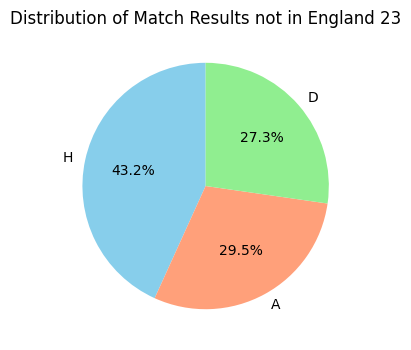

In [137]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results not in England 23")
plt.show()


In [138]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [139]:
train_columns=X_train.columns

In [140]:
test=seasons_df[(seasons_df['season'].isin(['season23']))]
test=test.copy()
test.drop('season', axis=1, inplace=True)

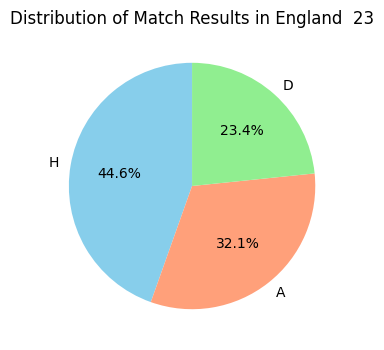

In [141]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England  23")
plt.show()


In [142]:
test=test.drop([ 'FTR'], axis=1)
y_test=test['label']

In [143]:
len(y_test)

552

### Scale the features

In [144]:
scaling_columns=X_train.columns

In [145]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [146]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

### Looping through each date and incrementally train and predict

In [147]:
best_params = {
    'colsample_bytree': 0.60,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 400,
    'gamma': 0.4, # low value means more splits
    'reg_alpha': 0.37, # higher values reduce over fitting
    'reg_lambda': 0.79, # higher values reduce over fittin
    'subsample': 0.25
}

model = xgb.XGBClassifier(**best_params)

In [148]:
best_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 100
}

model = xgb.XGBClassifier(**best_params)

In [149]:
# Initialize model and train on initial training data
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [150]:
test = test.sort_values('Date')
unique_dates = test['Date'].unique()

In [151]:
%%time
#Wall time: 2min 6s

predictions = []
probabilities = []
accuracies =  []
batchsizes = []
acc_batch = []


test_batches_with_predictions = []

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['Date'] == date].copy()
    X_test_batch = test_batch.drop(columns=['label', 'Date'])
    y_test_batch = test_batch['label']
    
    # Make predictions and get probabilities for the current batch
    y_pred_batch = model.predict(X_test_batch)
    y_proba_batch = model.predict_proba(X_test_batch)  # Get probabilities
    probabilities.extend(y_proba_batch)

    # Add predictions and probabilities to the test batch
    test_batch['predictions'] = y_pred_batch
    proba_df = pd.DataFrame(
        y_proba_batch, 
        columns=[f'proba_{class_name}' for class_name in label_encoder.classes_]
    )

    test_batch = pd.concat([test_batch.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

    test_batches_with_predictions.append(test_batch)
    
    # collect metrics
    predictions.extend(y_pred_batch)
    probabilities.extend(y_proba_batch)
    accuracies.append(accuracy_score(y_test_batch, y_pred_batch))
    batchsizes.append( len(X_test_batch))
    acc_batch.append(accuracy_score(y_test_batch, y_pred_batch) * len(X_test_batch))
    
    # Calculate and display metrics if desired (e.g., accuracy for this batch)
    print(f"Date: {date} - Accuracy: {accuracy_score(y_test_batch, y_pred_batch):.4f} - BatchSize: {len(X_test_batch)}")

    
    # Update model with the current batch
    X_all=np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all=pd.concat([y_train, y_test_batch])
    #import ipdb; ipdb.set_trace()
    model.fit(X_all, y_all)
    X_train=X_all
    y_train=y_all



# Collect all predictions for further evaluation if needed
test=test.copy()
#test['predictions'] = predictions

Date: 2023-08-04 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-05 00:00:00 - Accuracy: 0.5000 - BatchSize: 8
Date: 2023-08-06 00:00:00 - Accuracy: 0.3333 - BatchSize: 3
Date: 2023-08-12 00:00:00 - Accuracy: 0.2500 - BatchSize: 12
Date: 2023-08-18 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-19 00:00:00 - Accuracy: 0.7000 - BatchSize: 10
Date: 2023-08-20 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-25 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-26 00:00:00 - Accuracy: 0.7000 - BatchSize: 10
Date: 2023-08-27 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-09-02 00:00:00 - Accuracy: 0.1667 - BatchSize: 12
Date: 2023-09-15 00:00:00 - Accuracy: 0.5000 - BatchSize: 2
Date: 2023-09-16 00:00:00 - Accuracy: 0.7778 - BatchSize: 9
Date: 2023-09-17 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-09-19 00:00:00 - Accuracy: 0.3333 - BatchSize: 6
Date: 2023-09-20 00:00:00 - Accuracy: 0.3333 - BatchSize: 6
Date: 2023-09-22 00:00:00 - Accuracy

In [156]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [157]:
np.cumsum(acc_batch)

array([  1.,   5.,   6.,   9.,   9.,  16.,  17.,  17.,  24.,  24.,  26.,
        27.,  34.,  35.,  37.,  39.,  39.,  44.,  44.,  44.,  45.,  48.,
        49.,  55.,  60.,  60.,  65.,  73.,  76.,  78.,  85.,  86.,  86.,
        86.,  90.,  90.,  90.,  90.,  97.,  97., 102., 107., 111., 111.,
       115., 115., 116., 122., 127., 129., 135., 135., 136., 137., 142.,
       148., 152., 155., 155., 160., 161., 161., 165., 166., 166., 167.,
       168., 168., 169., 169., 170., 175., 175., 176., 180., 181., 186.,
       188., 189., 195., 197., 198., 201., 202., 208., 213., 214., 215.,
       220., 222., 223., 226., 227., 233., 238., 239., 243., 245., 247.,
       247., 252., 253., 256., 256., 257., 258., 258., 258., 262., 263.,
       264., 269.])

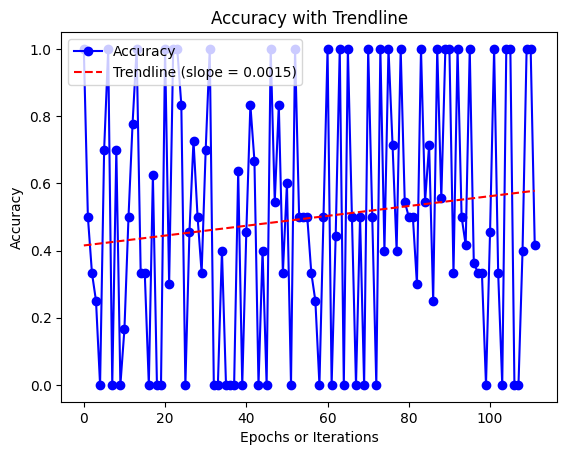

In [158]:

# Generate an array of indices (x-values)
x = np.arange(len(accuracies))

# Create a plot of the accuracies
plt.plot(x, accuracies, label='Accuracy', color='blue', marker='o')

# Calculate the trendline (slope) using polyfit (1st degree polynomial = line)
slope, intercept = np.polyfit(x, accuracies, 1)

# Generate the trendline y-values using the calculated slope and intercept
trendline = slope * x + intercept

# Plot the trendline
plt.plot(x, trendline, label=f'Trendline (slope = {slope:.4f})', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Epochs or Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy with Trendline')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [159]:
y_pred = test_with_predictions['predictions']

In [160]:
y_pred_labels = label_encoder.inverse_transform(test_with_predictions['predictions'])
y_test_labels = label_encoder.inverse_transform(test_with_predictions['label'])

In [161]:

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           A       0.43      0.46      0.45       177
           D       0.20      0.01      0.01       129
           H       0.52      0.76      0.62       246

    accuracy                           0.49       552
   macro avg       0.38      0.41      0.36       552
weighted avg       0.42      0.49      0.42       552



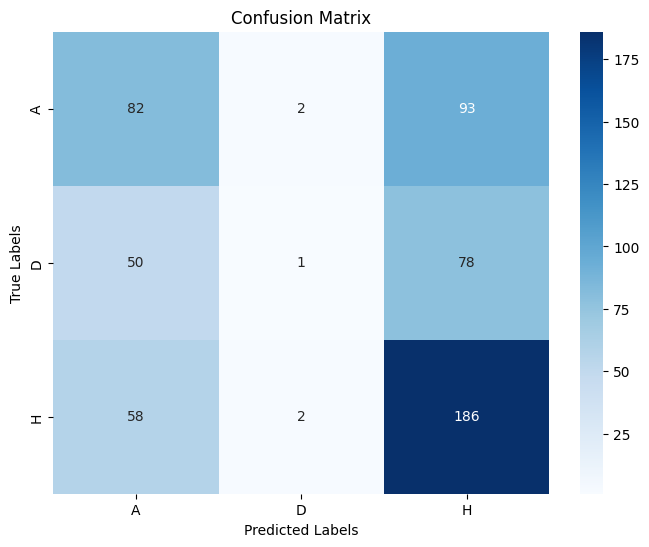

In [162]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
xlabel=ylabel=label_encoder.inverse_transform(model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xlabel, yticklabels=ylabel)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [163]:
# Get feature importances
feature_importances = model.feature_importances_


feature_names = train_columns  # If you're using a DataFrame for X_train
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

importance_df


,Feature,Importance
5,MaxH,0.200876
4,B365A,0.125569
9,MaxA,0.081304
6,AvgH,0.034494
10,AvgA,0.031223
7,MaxD,0.018223
31,diff.last3.loss,0.015292
48,diff.total.loss.whenHorA,0.014086
8,AvgD,0.013502
42,diff.last3.fouls,0.013392


### My Results

In [164]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [165]:
test[['predictions','proba_A','proba_D','proba_H']] = test_with_predictions[['predictions','proba_A','proba_D','proba_H']].values

In [166]:
my_predictions=test.sort_index()[['predictions','proba_A','proba_D','proba_H']]
my_predictions['predictions']=label_encoder.inverse_transform(my_predictions['predictions'].astype(int))

In [167]:
myresults=pd.concat([my_test_set, my_predictions ,], axis=1)

In [168]:
myresults=myresults[['Date','HomeTeam','AwayTeam', 'FTR', 'season', 'B365H', 'B365D', 'B365A','MaxH', 'AvgH', 'MaxD', 'AvgD', 'MaxA',
       'AvgA','predictions', 'proba_H', 'proba_D', 'proba_A']]

In [115]:
myresults.to_pickle('data/match_predictions.pkl')

In [169]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7728,2023-08-04,Sheffield Weds,Southampton,A,season23,3.10,3.4,2.30,3.31,3.14,3.47,3.38,2.35,2.28,A,0.313478,0.287603,0.398919
7729,2023-08-05,Blackburn,West Brom,H,season23,2.75,3.3,2.60,2.92,2.78,3.30,3.21,2.72,2.62,A,0.335553,0.312514,0.351933
7730,2023-08-05,Bristol City,Preston,D,season23,2.05,3.5,3.60,2.15,2.08,3.50,3.39,3.72,3.63,H,0.394391,0.298118,0.307491
7731,2023-08-05,Middlesbrough,Millwall,A,season23,1.91,3.3,4.33,2.05,1.95,3.60,3.47,4.33,3.97,H,0.401931,0.317900,0.280168
7732,2023-08-05,Norwich,Hull,H,season23,1.75,3.5,5.00,1.82,1.77,3.75,3.65,5.00,4.65,H,0.460043,0.289914,0.250042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,Rotherham,Cardiff,H,season23,3.40,3.4,2.20,3.50,3.40,3.45,3.35,2.23,2.16,A,0.319790,0.279000,0.401209
8276,2024-05-04,Stoke,Bristol City,H,season23,2.05,3.4,3.75,2.10,2.05,3.70,3.52,3.75,3.51,H,0.386557,0.317792,0.295651
8277,2024-05-04,Sunderland,Sheffield Weds,A,season23,2.70,3.4,2.55,2.87,2.73,3.40,3.25,2.80,2.62,D,0.323243,0.347872,0.328885
8278,2024-05-04,Swansea,Millwall,A,season23,2.05,3.5,3.60,2.07,2.04,3.61,3.50,3.76,3.57,H,0.364449,0.303369,0.332182


In [116]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7728,2023-08-04,Sheffield Weds,Southampton,A,season23,3.10,3.4,2.30,3.31,3.14,3.47,3.38,2.35,2.28,A,0.351324,0.262634,0.386042
7729,2023-08-05,Blackburn,West Brom,H,season23,2.75,3.3,2.60,2.92,2.78,3.30,3.21,2.72,2.62,A,0.348798,0.300149,0.351054
7730,2023-08-05,Bristol City,Preston,D,season23,2.05,3.5,3.60,2.15,2.08,3.50,3.39,3.72,3.63,H,0.400838,0.295318,0.303844
7731,2023-08-05,Middlesbrough,Millwall,A,season23,1.91,3.3,4.33,2.05,1.95,3.60,3.47,4.33,3.97,H,0.403772,0.316668,0.279560
7732,2023-08-05,Norwich,Hull,H,season23,1.75,3.5,5.00,1.82,1.77,3.75,3.65,5.00,4.65,H,0.446642,0.290846,0.262513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,Rotherham,Cardiff,H,season23,3.40,3.4,2.20,3.50,3.40,3.45,3.35,2.23,2.16,A,0.306151,0.292999,0.400850
8276,2024-05-04,Stoke,Bristol City,H,season23,2.05,3.4,3.75,2.10,2.05,3.70,3.52,3.75,3.51,H,0.376922,0.303987,0.319091
8277,2024-05-04,Sunderland,Sheffield Weds,A,season23,2.70,3.4,2.55,2.87,2.73,3.40,3.25,2.80,2.62,A,0.325136,0.317534,0.357330
8278,2024-05-04,Swansea,Millwall,A,season23,2.05,3.5,3.60,2.07,2.04,3.61,3.50,3.76,3.57,H,0.387465,0.301924,0.310611
